In [12]:
from model import DenoisingUNet
from utils import *
import matplotlib.pyplot as plt
import torch
import numpy as np
sampleRate = 49.95
#----
seed = 42
# Python
import random as python_random
python_random.seed(seed)
# NumPy (random number generator used for sampling operations)
rng = np.random.default_rng(seed)

In [13]:
def generate_sample(waveform, slowness, SNR, N_ch):
    
    fmin, fmax = 1.0, 10.0
    samp = 50.
    gauge = 8.
    gutter = 100
    
    N_t = 2048
    start = 2600
    end = start + N_t
    t_slice = slice(start, end)
    
    noise = rng.random((N_ch, N_t + 2*gutter))
    noise = taper_filter(noise, fmin=fmin, fmax=fmax, samp_DAS=samp)[:, gutter:-gutter]
    noise = noise.reshape(N_ch, N_t)
    
    peak = np.abs(waveform).max()
    
    shift = gauge * slowness * samp
    amp = 2 * np.sqrt(SNR) / peak   
    
    sample = np.zeros((N_ch, N_t))
    
    for i in range(N_ch):
        sample[i] = amp * np.roll(waveform, int(i*shift))[t_slice]

    noisy_sample = sample + noise
    scale = noisy_sample.std()
    noisy_sample /= scale
    
    return sample, noisy_sample, noise, scale, amp

In [14]:
N_sub = 11
batch_size = 32
hidden_layers = 4
learning_rate = 5e-4
num_epochs = 2000

In [15]:
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('../data/runs/synthetic-run-extended/checkpoint-epoch-2000.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();

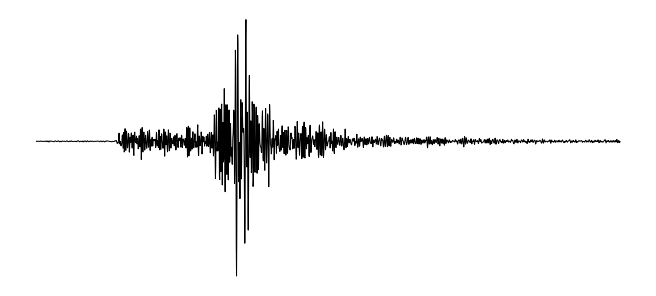

In [16]:
# Load data'
data = np.load('../data/synthetics/waveforms.npy')
N_ch, N_t = data.shape
t_slice = slice(N_t//4, 3*N_t//4)
scaled_data = np.zeros_like(data)

# Normalise waveforms
for i, wv in enumerate(data):
    scaled_data[i] = wv / wv[t_slice].std()

# Split data train-test
split = int(0.8 * N_ch)
train_data = scaled_data[:split]
test_data = scaled_data[split:]

# Select waveform 10 for inspection

n = 10

Nt = 2048
start = 2600
end = start + Nt
t_slice = slice(start, end)
master = test_data[n]

# Plot waveform
plt.figure(figsize=(9, 4), constrained_layout=True)
plt.plot(master[t_slice], "k", lw=1)
plt.axis("off")
plt.show()


In [17]:
def reconstruct(model, data, N_sub=11):
    
    reconstructions = np.zeros_like(data)
    N_ch, N_t = data.shape

    masks = np.ones((N_ch, N_sub, N_t, 1))
    eval_samples = np.zeros_like(masks)

    gutter = N_sub // 2
    mid = N_sub // 2

    for i in range(gutter):
        masks[i, i] = 0
        eval_samples[i, :, :, 0] = data[:N_sub]

    for i in range(gutter, N_ch - gutter):
        start = i - mid
        stop = i + mid + 1

        masks[i, mid] = 0
        eval_samples[i, :, :, 0] = data[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, i - N_ch] = 0
        eval_samples[i, :, :, 0] = data[-N_sub:]
    
    sample = eval_samples * masks
    sample = torch.Tensor(sample).reshape((N_ch,1,N_sub, N_t))
    c_mask = (1-masks).reshape((N_ch,1,N_sub, N_t))
    results = model(sample).detach().numpy()*c_mask
    reconstructions = np.sum(results.squeeze(), axis=1)[:,: :]
    
    return reconstructions

In [18]:
results_dict = {}
SNRs = (10, 1, 0.1)

gauge = 8.
samp = 50.

# Loop over SNR values
for SNR in SNRs:
    
    # Generate a synthetic sample
    sample, noisy_sample, noise, scale, amp = generate_sample(master, slowness=1/(gauge*samp), SNR=SNR, N_ch=300)
    # Get a J-invariant reconstruction    
    rec = reconstruct(model,noisy_sample)
    # filter output (optional)
    # rec = taper_filter(rec,fmin=1, fmax=10, samp_DAS=samp)

    #Store results
    results_dict[SNR] = {
        "sample": sample,
        "noisy_sample": noisy_sample,
        "noise": noise,
        "scale": scale,
        "rec": rec,
        "amp": amp,
    }

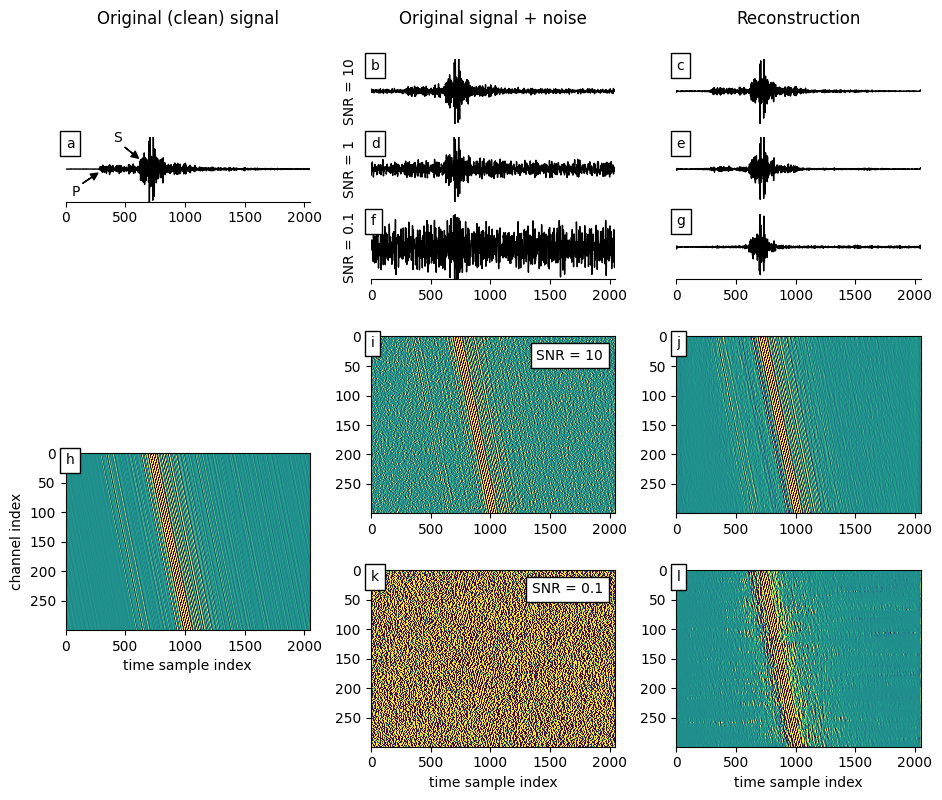

In [19]:
fontsize = 12
titles = ("Original (clean) signal", "Original signal + noise", "Reconstruction")
letters = "bcadefghijklmnopqrstuvwxyz"

waterfall_params = {
    "cmap": "viridis",
    "vmin": -0.25,
    "vmax": 0.25,
    "aspect": "auto",
    "interpolation": "antialiased",
    "rasterized": True,
}

letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}

# Draw canvas
fig = plt.figure(figsize=(9.5, 8), dpi=100)
gs = fig.add_gridspec(18, 3)

axes = []

count = 0


""" Panel a) - clean/noisy/reconstructed waveforms at different SNR """

for i, SNR in enumerate(SNRs):
    result = results_dict[SNR]
    contents = (result["sample"], result["noisy_sample"] * result["scale"], result["rec"] * result["scale"])
    
    for j, content in enumerate(contents):
        if (j == 0) and (i > 1):
            continue
            
        ax = fig.add_subplot(gs[2*i:2*(i+1), j])
        axes.append(ax)
        
        spines = ("left", "top", "right")
        
        keep_axis = ((j == 0) and (i == 1)) or ((j > 0) and (i == 2))
        
        if (i == 1) or (j > 0):
            ax.plot(content[0] / result["amp"], c="k", lw=1)
        
        if i + j > 0:
            ax.text(x=0.0, y=1.0, transform=ax.transAxes, s=letters[count], **letter_params)
            count += 1
        
        ax.set_xlim((0, 2048))
        ax.set_ylim((-12, 12))
        
        ax.set_yticks([])
        
        if j == 1:
            ax.set_ylabel(f"SNR = {SNR}", labelpad=10)
            
        if i == 0:
            ax.set_title(titles[j], fontsize=12, pad=25)
        
        if not keep_axis:
            spines = ("left", "top", "right", "bottom")
            ax.set_xticks([])
            
        for spine in spines:
            ax.spines[spine].set_visible(False)

ax = axes[3]
arrowprops = {"width": 0.1, "headwidth": 5, "headlength": 5, "facecolor": "k"}
ax.annotate(text="P", xy=(270, -1.5), xytext=(50, -10), arrowprops=arrowprops)
ax.annotate(text="S", xy=(610, 4), xytext=(400, 10), arrowprops=arrowprops)


""" Panel b) - Waterfall plot of input sample """

ax = fig.add_subplot(gs[9:15, 0])
axes.append(ax)

ax.imshow(result["sample"] / result["amp"], **waterfall_params)

ax.text(x=0.0, y=1.0, transform=ax.transAxes, s=letters[count], **letter_params)
count += 1

ax.set_ylabel("channel index")
ax.set_xlabel("time sample index")


""" Panels c-f) - Waterfall plot of SNR = {10, 0.1} """

for i, SNR in enumerate((SNRs[0], SNRs[2])):
    result = results_dict[SNR]
    contents = (result["noisy_sample"] * result["scale"], result["rec"] * result["scale"])
    
    offset = 6

    for j, content in enumerate(contents):
        ax = fig.add_subplot(gs[6+offset*i:6+offset*(i+1), j+1])
        axes.append(ax)

        ax.imshow(content / result["amp"], **waterfall_params)
        
        if j == 0:
            ax.text(x=0.95, y=0.93, transform=ax.transAxes, s=f"SNR = {SNR}", ha="right", **letter_params)

        ax.text(x=0.0, y=1.0, transform=ax.transAxes, s=letters[count], **letter_params)  
        count += 1
        
        if i == 1:
            ax.set_xlabel("time sample index")


# Adjust subplot positions
plt.subplots_adjust(hspace=0.5, wspace=0.25, left=0.07, right=0.97, bottom=0.07, top=0.93)

# Fine-tuning positions
for ax in axes[-5:]:
    pos = ax.get_position()
    pos.y1 = pos.y1 - 0.055
    ax.set_position(pos)

# plt.savefig("figures/examples_synthetics.pdf")
plt.show()

In [20]:
N_SNR = 20
N_ch = 300
N_t = 2048

SNRs = np.power(10, np.linspace(-3, 4, N_SNR))

samples = np.zeros((N_SNR, N_ch, N_t))
noisy_samples = np.zeros_like(samples)
recs = np.zeros_like(samples)

# Loop over SNRs
for i, SNR in enumerate(SNRs):
    print(i, SNR)
    
    # Generate sample
    sample, noisy_sample, noise, scale, _ = generate_sample(master, slowness=1/(samp*gauge), SNR=SNR, N_ch=N_ch)
    
    samples[i] = sample / scale
    noisy_samples[i] = noisy_sample
    # Get J-invariant reconstruction
    recs[i] = reconstruct(model, noisy_sample)
    
    # rec = taper_filter(rec,fmin=1, fmax=10, samp_DAS=samp)

# MSE for each sample and each trace
MSE_SNR = np.mean((samples - recs)**2, axis=-1) / np.mean(samples**2, axis=-1)

# Mean MSE for each sample
MMSE_SNR = np.mean(MSE_SNR, axis=-1)
std_MSE_SNR = np.std(MSE_SNR, axis=-1)

print("Done")

0 0.001
1 0.002335721469090121
2 0.00545559478116852
3 0.012742749857031334
4 0.029763514416313176
5 0.06951927961775606
6 0.1623776739188721
7 0.37926901907322497
8 0.8858667904100823
9 2.069138081114788
10 4.832930238571752
11 11.288378916846883
12 26.366508987303554
13 61.58482110660255
14 143.8449888287663
15 335.9818286283781
16 784.7599703514607
17 1832.9807108324337
18 4281.332398719387
19 10000.0
Done


In [21]:
N_slowness = 50
N_ch = 300
N_t = 2048

slownesses = np.linspace(1/20_000, 1/300, N_slowness)

samples = np.zeros((N_slowness, N_ch, N_t))
noisy_samples = np.zeros_like(samples)
recs = np.zeros_like(samples)

# Loop over slownesses
for i, slowness in enumerate(slownesses):
    print(i, slowness)
    
    # Generate synthetic sample
    sample, noisy_sample, noise, scale, _ = generate_sample(master, slowness=slowness, SNR=1, N_ch=N_ch)
    
    samples[i] = sample / scale
    noisy_samples[i] = noisy_sample
    # Get J-invariant reconstruction
    noisy_sample = torch.unsqueeze(torch.Tensor(noisy_sample).squeeze(), 1).reshape((1,1,noisy_sample.shape[0],noisy_sample.shape[1]))    
    recs[i] = model(noisy_sample).detach().numpy()

# MSE for each sample and each trace
MSE_slow = np.mean((samples - recs)**2, axis=-1) / np.mean(samples**2, axis=-1)

# Mean MSE for each sample
MMSE_slow = np.mean(MSE_slow, axis=-1)
std_MSE_slow = np.std(MSE_slow, axis=-1)

print("Done")

0 5e-05
1 0.00011700680272108845
2 0.00018401360544217688
3 0.00025102040816326536
4 0.0003180272108843538
5 0.0003850340136054422
6 0.0004520408163265307
7 0.0005190476190476191
8 0.0005860544217687075
9 0.000653061224489796
10 0.0007200680272108844
11 0.0007870748299319729
12 0.0008540816326530614
13 0.0009210884353741497
14 0.0009880952380952382
15 0.0010551020408163265
16 0.001122108843537415
17 0.0011891156462585034
18 0.001256122448979592
19 0.0013231292517006802
20 0.0013901360544217687
21 0.0014571428571428572
22 0.0015241496598639456
23 0.0015911564625850341
24 0.0016581632653061226
25 0.0017251700680272109
26 0.0017921768707482993
27 0.0018591836734693878
28 0.0019261904761904763
29 0.001993197278911565
30 0.0020602040816326533
31 0.0021272108843537418
32 0.0021942176870748302
33 0.0022612244897959187
34 0.002328231292517007
35 0.0023952380952380957
36 0.002462244897959184
37 0.0025292517006802726
38 0.0025962585034013607
39 0.002663265306122449
40 0.0027302721088435376
41 0.

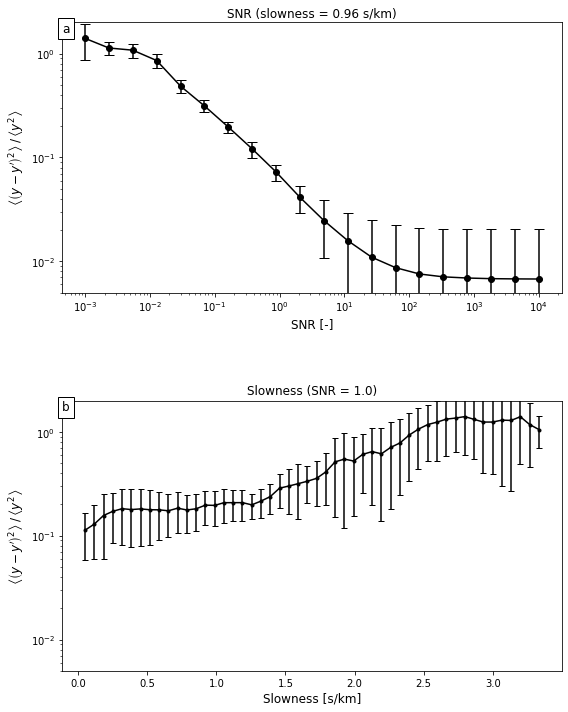

In [22]:
font = 12

letter_params = {
    "fontsize": font,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}


# Draw canvas
fig, axes = plt.subplots(nrows=2, figsize=(8, 10),sharey=True)


""" Panel a: effect SNR """

ax = axes[0]

ax.errorbar(SNRs, MMSE_SNR, yerr=std_MSE_SNR, fmt="o-", capsize=5., c="k")

ax.set_ylim((0.005, 2))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("SNR [-]", fontsize=font)
ax.set_ylabel(r"$\left< \left( y - y' \right)^2 \right> \, / \, \left< y^2 \right>$", fontsize=font)
ax.set_title("SNR (slowness = 0.96 s/km)", fontsize=font)
ax.text(x=0.0, y=1.0, transform=ax.transAxes, s="a", **letter_params)


""" Panel b: effect slowness """

ax = axes[1]

ax.errorbar(1e3 * slownesses, MMSE_slow, yerr=std_MSE_slow, fmt="o-", capsize=3., c="k", ms=3)

ax.set_ylabel(r"$\left< \left( y - y' \right)^2 \right> \, / \, \left< y^2 \right>$", fontsize=font)
ax.set_xlabel("Slowness [s/km]", fontsize=font)
ax.set_yscale("log")
# ax.set_ylim((0, 2))
ax.set_title("Slowness (SNR = 1.0)", fontsize=font)
ax.text(x=0.0, y=1.0, transform=ax.transAxes, s="b", **letter_params)


plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

# plt.savefig("figures/synthetics_SNR_slowness.pdf")
plt.show()